```{contents}
```
## Merge

In LangGraph, a **merge** is the control-flow operation that **combines multiple execution paths into a single continuation point**, while **reconciling their partial state updates into one coherent global state**.
It is fundamental for parallelism, multi-agent coordination, and robust workflow design.

---

### **1. Why Merge Is Needed**

Modern LLM systems frequently **split work** and later **recombine results**.

Typical scenarios:

| Scenario             | Why merge                    |
| -------------------- | ---------------------------- |
| Parallel tool calls  | Combine independent results  |
| Multi-agent work     | Aggregate agent outputs      |
| Map–Reduce pipelines | Reduce many into one         |
| Consensus workflows  | Merge opinions into decision |
| Verification stages  | Join main + checker results  |

Without merge, parallel execution would **fragment state** and break determinism.

---

### **2. Conceptual Model**

```
        Task A ──┐
                 ├── Merge ──> Next Stage
        Task B ──┘
```

Each branch produces **partial state**, and the merge operation produces a **single updated state**.

---

### **3. How Merge Works Internally**

LangGraph merge consists of **three phases**:

1. **Synchronization** — wait for all incoming edges
2. **State Collection** — gather all partial updates
3. **State Reduction** — apply reducers to combine updates

---

### **4. Reducers: The Heart of Merge**

Reducers define **how state fields are merged**.

```python
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph

def concat(a, b):
    return a + b

class State(TypedDict):
    reports: Annotated[list[str], concat]
```

Now when multiple nodes update `reports`, LangGraph **automatically concatenates** them at merge time.

---

### **5. Basic Parallel + Merge Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated

def add(a, b): return a + b

class State(TypedDict):
    results: Annotated[list[int], add]

def worker1(state): return {"results": [1]}
def worker2(state): return {"results": [2]}

def final(state):
    return {"results": state["results"]}

builder = StateGraph(State)

builder.add_node("w1", worker1)
builder.add_node("w2", worker2)
builder.add_node("final", final)

builder.set_entry_point("w1")
builder.add_edge("w1", "final")
builder.add_edge("w2", "final")

builder.compile().invoke({"results": []})
```

Execution:

```
w1 → results=[1]
w2 → results=[2]
merge → results=[1,2]
```

---

### **6. Merge with Fan-Out / Fan-In**

```python
router → { agent1, agent2, agent3 } → merge → answer
```

Used in:

* Multi-agent systems
* Parallel document analysis
* Search + reasoning pipelines

---

### **7. Determinism Guarantees**

LangGraph ensures:

| Property        | Guarantee                         |
| --------------- | --------------------------------- |
| Synchronization | Merge waits for all inputs        |
| Determinism     | Reducers define consistent output |
| Safety          | No race conditions                |
| Reproducibility | Same inputs → same merged state   |

---

### **8. Merge Patterns**

| Pattern               | Purpose               |
| --------------------- | --------------------- |
| Fan-Out → Merge       | Parallel speed-up     |
| Map → Reduce          | Batch processing      |
| Debate → Consensus    | Multi-agent alignment |
| Verify → Confirm      | Safety & correctness  |
| Speculative execution | Fast-first answer     |

---

### **9. Production Controls**

| Mechanism      | Purpose              |
| -------------- | -------------------- |
| Timeouts       | Avoid deadlock       |
| Partial merge  | Handle failures      |
| Fallback merge | Graceful degradation |
| Audit logging  | Trace decisions      |

---

### **10. Mental Model**

> **Merge is not just joining paths — it is controlled reconciliation of parallel knowledge.**

It transforms **concurrency** into **coherent intelligence**.


### Demonstration

In [5]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END

# ----------------------------
# Reducer
# ----------------------------
def concat(a, b):
    return a + b

# ----------------------------
# State
# ----------------------------
class State(TypedDict):
    results: Annotated[list[int], concat]

# ----------------------------
# Workers
# ----------------------------
def start(state):
    return state

def worker1(state):
    return {"results": [1]}

def worker2(state):
    return {"results": [2]}

def worker3(state):
    return {"results": [3]}

def final(state):
    print("Merged State:", state)
    return state

# ----------------------------
# Build Graph
# ----------------------------
builder = StateGraph(State)

builder.add_node("start", start)
builder.add_node("w1", worker1)
builder.add_node("w2", worker2)
builder.add_node("w3", worker3)
builder.add_node("final", final)

# Entry
builder.set_entry_point("start")

# Fan-out
builder.add_edge("start", "w1")
builder.add_edge("start", "w2")
builder.add_edge("start", "w3")

# Fan-in (Merge)
builder.add_edge("w1", "final")
builder.add_edge("w2", "final")
builder.add_edge("w3", "final")

builder.add_edge("final", END)

# ----------------------------
# Run
# ----------------------------
graph = builder.compile()
graph.invoke({"results": []})


Merged State: {'results': [1, 2, 3]}


{'results': [1, 2, 3, 1, 2, 3]}

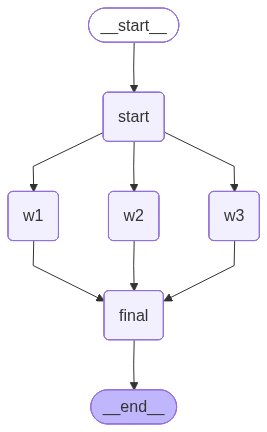

In [6]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())